## Syed Hashim Ali Gilani
## Combining Methods: Ensembles

In [ ]:
pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.7 MB/s eta 0:00:00


In [ ]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import liftChart, gainsChart

%matplotlib inline

Colab environment detected.


## To receive credit, your answers must be based on the instructor's lectures, the example code provided by the instructor, and textbooks for the course, not any other sources such as the Internet, AI tools, or other people. Use random_state=1 when needed.

# eBay Auctions
Using the eBay auction data (file _eBayAuctions.csv_) with variable Competitive as the outcome variable, partition the data into training (60%) and validation (40%).

In [ ]:
ebay_df = pd.read_csv('eBayAuctions.csv')
ebay_df.head()

,Category,Currency,SellerRating,Duration,EndDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


## (a)
Tune hyperparameters to train a single Decision Tree using `DecisionTreeClassifier()`.
Looking at the validation data, what is the overall accuracy? Produce the gains and lift charts for the validation data. What is the lift on the first decile? Also report F1-Score (especially useful if the classes are imbalanced) and Tree Depth (from the best model)

Best CV score (mean accuracy): 0.8774261603375526
Best params: {'max_depth': 10, 'min_impurity_decrease': 0.0004, 'min_samples_split': 19}
Best tree depth: 10

Validation set performance:
Confusion Matrix (Accuracy 0.8758)

       Prediction
Actual   0   1
     0 328  34
     1  64 363

Overall accuracy (validation): 0.8758
F1-score (validation): 0.8811
Lift at 1st decile: 1.756
Tree depth (best model): 10


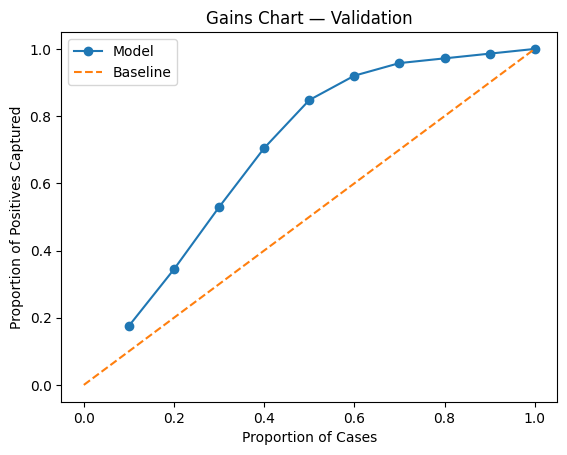

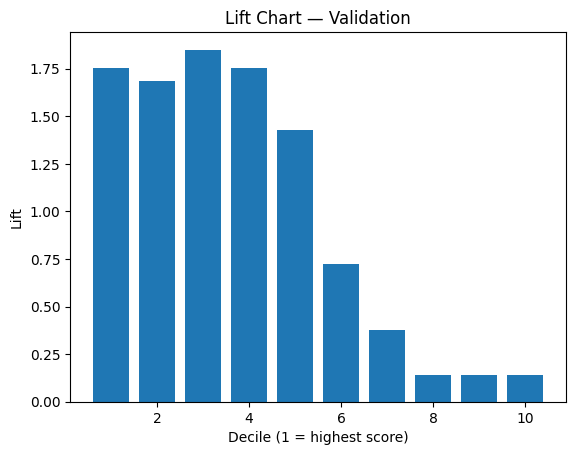

In [ ]:


# Split data
X = ebay_df.drop(columns=['Competitive'])
y = ebay_df['Competitive'].astype(int)

# One hot encode categoricals with m dummies
X = pd.get_dummies(X, drop_first=False)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from dmba import classificationSummary

train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.40, random_state=1, stratify=y
)

# Hyperparameter tuning
param_grid = {
    'max_depth': list(range(2, 16)),
    'min_samples_split': list(range(15, 25)),
    'min_impurity_decrease': [0.0004, 0.0005, 0.0006]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_grid=param_grid,
    cv=5, n_jobs=-1
)
grid.fit(train_X, train_y)
best_dt = grid.best_estimator_

print("Best CV score (mean accuracy):", grid.best_score_)
print("Best params:", grid.best_params_)
print("Best tree depth:", best_dt.get_depth())

# Validation metrics
valid_pred = best_dt.predict(valid_X)
valid_proba = best_dt.predict_proba(valid_X)[:, 1]

print("\nValidation set performance:")
classificationSummary(valid_y, valid_pred)

acc = accuracy_score(valid_y, valid_pred)
f1  = f1_score(valid_y, valid_pred)

# Manual Gains & Lift Charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_gains_and_lift(y_true, y_score):
    df = pd.DataFrame({'y': pd.Series(y_true).astype(int).values,
                       'p': pd.Series(y_score).astype(float).values})
    df = df.sort_values('p', ascending=False).reset_index(drop=True)

    # Create deciles
    n = len(df)
    decile_edges = (np.arange(1, 11) * (n / 10.0)).astype(int)
    df['decile'] = 10
    start = 0
    for d, end in enumerate(decile_edges, start=1):
        df.loc[start:end, 'decile'] = d
        start = end

    gains_by_decile = df.groupby('decile', sort=True)['y'].sum()
    cum_gains = gains_by_decile.cumsum() / df['y'].sum()
    x_prop = np.arange(1, 11) / 10.0

    # Gains chart
    plt.figure()
    plt.plot(x_prop, cum_gains.values, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
    plt.xlabel('Proportion of Cases')
    plt.ylabel('Proportion of Positives Captured')
    plt.title('Gains Chart — Validation')
    plt.legend()

    # Lift chart
    base_rate = df['y'].mean()
    cases_per_decile = n / 10.0
    lift_by_decile = gains_by_decile / (cases_per_decile * base_rate)

    plt.figure()
    plt.bar(np.arange(1, 11), lift_by_decile.values)
    plt.xlabel('Decile (1 = highest score)')
    plt.ylabel('Lift')
    plt.title('Lift Chart — Validation')

    return float(lift_by_decile.iloc[0])

lift_at_10_manual = plot_gains_and_lift(valid_y, valid_proba)


print(f"\nOverall accuracy (validation): {acc:.4f}")
print(f"F1-score (validation): {f1:.4f}")
print(f"Lift at 1st decile: {lift_at_10_manual:.3f}")
print(f"Tree depth (best model): {best_dt.get_depth()}")


Looking at the validation data, the overall accuracy of the decision tree model is 0.8758, with an F1 score of 0.8811. The best model was obtained using max_depth = 10, min_samples_split = 19, and min_impurity_decrease = 0.0004, resulting in a tree depth of 10. The gains and lift charts show that the model performs well, capturing a large proportion of the positive cases early on. The lift on the first decile is 1.756, which means that the model identifies about 1.76 times more positive cases in the top 10% of predictions compared to random guessing. Overall, the decision tree shows strong predictive performance and good separation between the classes on the validation data.

## (b)
Fit a bagged tree by tuning hyperparameters. For the validation data, what is the overall accuracy and F1-score? Produce the gains and lift charts for the validation data. What is the lift on the first decile? Briefly discuss how the performance of the Bagging model compares to the single optimized tree. Which model shows better generalization, and what does this suggest about the variance of the single tree model?

Best CV score (mean accuracy): 0.891790030751627
Best params: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}

Validation set performance:
Confusion Matrix (Accuracy 0.8872)

       Prediction
Actual   0   1
     0 332  30
     1  59 368

Overall accuracy (validation): 0.8872
F1-score (validation): 0.8921
Lift at 1st decile: 1.827


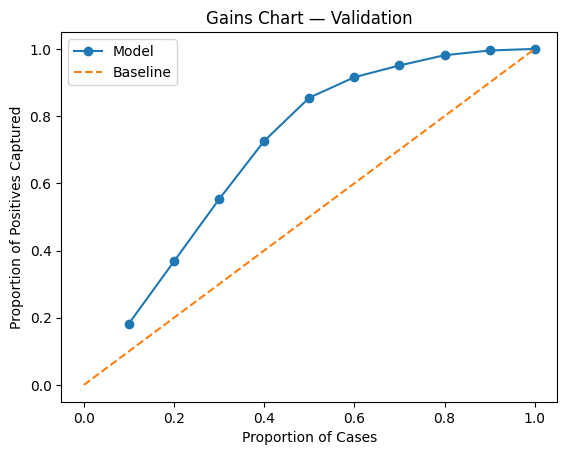

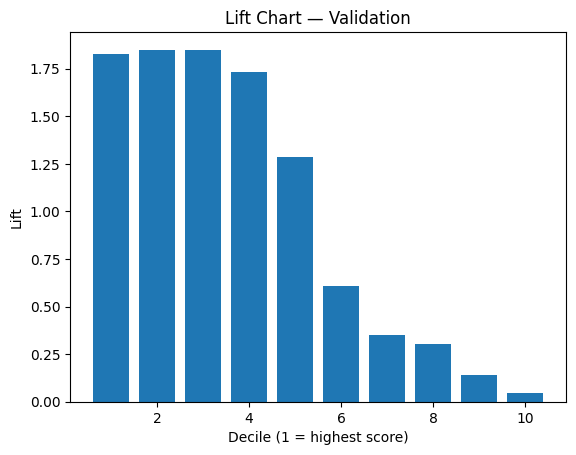

In [ ]:


# Decision tree as
base_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=19,
    min_impurity_decrease=0.0004,
    random_state=1
)

# Hyperparameter grid for Bagging
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(
    BaggingClassifier(estimator=base_tree, random_state=1),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid.fit(train_X, train_y)
best_bagging = grid.best_estimator_

print("Best CV score (mean accuracy):", grid.best_score_)
print("Best params:", grid.best_params_)

# Validation metrics
valid_pred = best_bagging.predict(valid_X)
valid_proba = best_bagging.predict_proba(valid_X)[:, 1]

print("\nValidation set performance:")
classificationSummary(valid_y, valid_pred)

acc_bag = accuracy_score(valid_y, valid_pred)
f1_bag  = f1_score(valid_y, valid_pred)

# Gains & Lift
lift_at_10_bag = plot_gains_and_lift(valid_y, valid_proba)

print(f"\nOverall accuracy (validation): {acc_bag:.4f}")
print(f"F1-score (validation): {f1_bag:.4f}")
print(f"Lift at 1st decile: {lift_at_10_bag:.3f}")


For the validation data, the bagged tree achieved an overall accuracy of 0.8872 and an F1-score of 0.8921. The best model was tuned with n_estimators = 50, max_samples = 1.0, and max_features = 1.0. The lift on the first decile is 1.827, which shows a slight improvement compared to the single optimized tree from Part (a) that had a lift of 1.756. The gains and lift charts for the validation data show that the bagging model performs well, capturing a higher proportion of positive cases in the top deciles. Compared to the single tree, the bagged model shows better generalization and slightly higher predictive performance. This improvement suggests that bagging helps reduce the variance of the single decision tree by averaging results from multiple trees, making the overall model more stable and less sensitive to the training data.

## (c)
Fit a random forest (use `RandomForestClassifier`) by tuning hyperparameters. Produce the gains and lift charts for the validation data. Compare the bagged tree to the random forest in terms of validation accuracy and lift on first decile. How are the two methods conceptually different? Extract and plot the feature importances from the final $\mathbf{best\_random\_forest}$ model. List the top 5 predictors of auction competitiveness.

Best CV score (mean accuracy): 0.9044732889937782
Best params: {'max_depth': 12, 'max_features': 1.0, 'min_samples_split': 5, 'n_estimators': 150}
Best tree depth: 12

Validation set performance:
Confusion Matrix (Accuracy 0.9037)

       Prediction
Actual   0   1
     0 333  29
     1  47 380

Overall accuracy (validation): 0.9037
F1-score (validation): 0.9091
Lift at 1st decile: 1.827

Top 5 Predictors of Auction Competitiveness:
ClosePrice               0.428350
OpenPrice                0.349376
SellerRating             0.064865
Currency_EUR             0.035464
Category_Toys/Hobbies    0.014904
dtype: float64


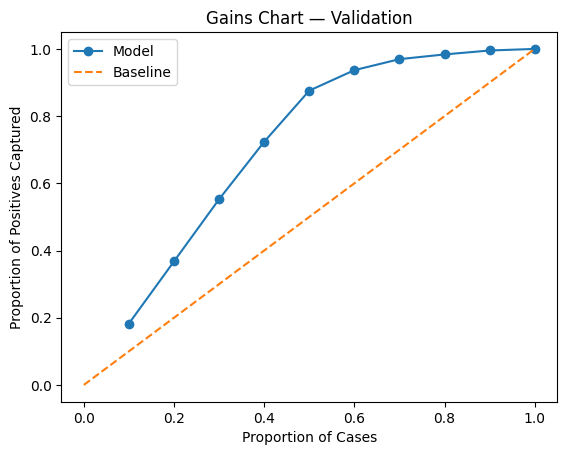

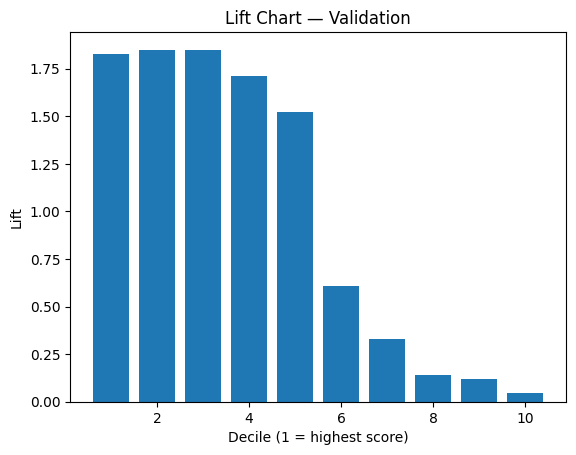

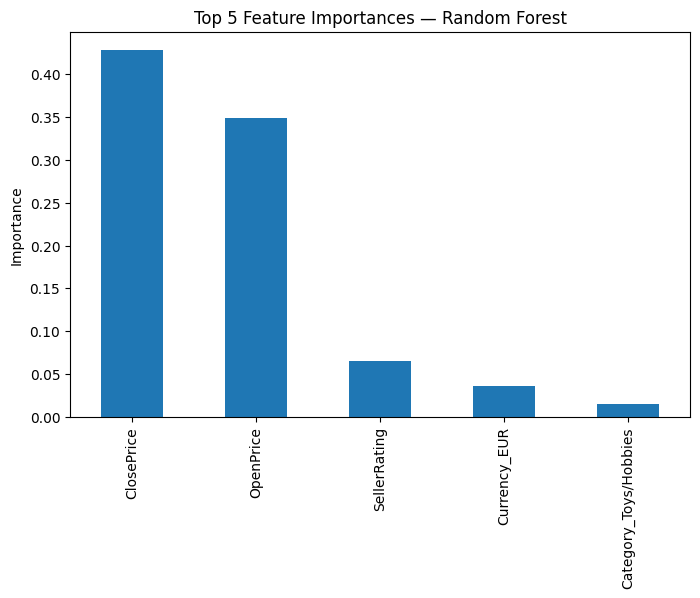

In [ ]:
# Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [6, 8, 10, 12],
    'max_features': [0.6, 0.8, 1.0],
    'min_samples_split': [5, 10, 15]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=1),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid.fit(train_X, train_y)
best_rf = grid.best_estimator_

print("Best CV score (mean accuracy):", grid.best_score_)
print("Best params:", grid.best_params_)
print("Best tree depth:", best_rf.max_depth)

# Validation metrics
valid_pred = best_rf.predict(valid_X)
valid_proba = best_rf.predict_proba(valid_X)[:, 1]

print("\nValidation set performance:")
classificationSummary(valid_y, valid_pred)

acc_rf = accuracy_score(valid_y, valid_pred)
f1_rf  = f1_score(valid_y, valid_pred)

# Gains & Lift charts
lift_at_10_rf = plot_gains_and_lift(valid_y, valid_proba)

# Final metrics
print(f"\nOverall accuracy (validation): {acc_rf:.4f}")
print(f"F1-score (validation): {f1_rf:.4f}")
print(f"Lift at 1st decile: {lift_at_10_rf:.3f}")

# Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(best_rf.feature_importances_, index=train_X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

top_features = feat_importances.head(5)
print("\nTop 5 Predictors of Auction Competitiveness:")
print(top_features)

# Plot
plt.figure(figsize=(8,5))
top_features.plot(kind='bar')
plt.title('Top 5 Feature Importances — Random Forest')
plt.ylabel('Importance')
plt.show()


The random forest model achieved an overall accuracy of 0.9037 and an F1-score of 0.9091 on the validation data. The best model was tuned with n_estimators = 150, max_depth = 12, max_features = 1.0, and min_samples_split = 5. The lift on the first decile is 1.827, which is about the same as the bagged tree model but with slightly higher accuracy and F1-score. The gains and lift charts show that the random forest captures a high proportion of the competitive auctions early on, indicating strong predictive performance. Compared to the bagged tree, the random forest performs better overall and shows stronger generalization. Conceptually, random forests improve on bagging by adding random feature selection at each split, which helps reduce correlation between trees and further lowers variance. From the feature importance plot, the top predictors of auction competitiveness are ClosePrice, OpenPrice, SellerRating, Currency_EUR, and Category_Toys/Hobbies, with ClosePrice and OpenPrice having the largest impact on the model’s predictions.

## (d)
Write a brief summary of your findings by answering the following questions:

Compare the best performance metrics (Accuracy, F1-Score) across the three models (Single Tree, Bagging, Random Forest).

Based on your results, which model is best suited for classifying auction competitiveness, and why?

Using your Random Forest Feature Importance results, provide one actionable insight for an eBay seller based on the features that most predict a competitive auction.

Comparing the three models, the single decision tree achieved an accuracy of 0.8758 and an F1-score of 0.8811, the bagged tree improved slightly with an accuracy of 0.8872 and an F1-score of 0.8921, and the random forest performed the best with an accuracy of 0.9037 and an F1-score of 0.9091. Based on these results, the random forest model is best suited for classifying auction competitiveness because it provides the highest validation performance and the most stable generalization. The improvement comes from the way random forests combine bagging with random feature selection, which reduces correlation between trees and minimizes overfitting compared to a single tree or pure bagging. From the feature importance results, ClosePrice and OpenPrice were the strongest predictors of a competitive auction, followed by SellerRating, Currency_EUR, and Category_Toys/Hobbies. An actionable insight for eBay sellers would be to start auctions at a reasonable opening price and aim for listings with higher closing prices, as these price related factors most strongly influence whether an auction becomes competitive.